# Demo: Hierarchical Lattice Quantization

This notebook demonstrates hierarchical nested lattice quantization using the D4 lattice, showing how multi-level quantization can improve rate-distortion performance.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.quantizers.lattice.nlq import NLQ as NLQ
from src.quantizers.lattice.hnlq import HNLQ as HNLQ
from src.quantizers.lattice.utils import get_d4, closest_point_Dn, SIG_D4

## A simple example
of using hierarchical lattice quantization to quantize a 4D vector.

We will take $x=(1.2,-0.7,2.4,0.3)$

In [3]:
d = 4
q = 2
M = 2
G = get_d4()
Q_nn = lambda x: closest_point_Dn(x)  # D4 lattice closest point algorithm
beta = 1

test_sample = np.array([1.2, -0.7, 2.4, 0.3])

print("Original Sample:", np.round(test_sample, 3))

quantizer = HNLQ(
            G=G,
            Q_nn=Q_nn,
            q=q,
            beta=beta,
            alpha=1.0,
            M=M,
            eps=np.zeros(d),
            dither=np.zeros(d)
        )
enc, T = quantizer.encode(test_sample, with_dither=False)
print(f"\t encoded (q={q}, M={M},T={T})")
xh = quantizer.decode(enc,T, with_dither=False)
print(f"\t bit vector at m=0 is {enc[0]})")
print(f"\t bit vector at m=1 is {enc[1]})")
error = np.linalg.norm(test_sample - xh)
print("\t Reconstructed Sample:", np.round(xh, 3))
print(f"Reconstruction Error (L2 norm): {error:.6f}")

Original Sample: [ 1.2 -0.7  2.4  0.3]
	 encoded (q=2, M=2,T=0)
	 bit vector at m=0 is [1 0 0 0])
	 bit vector at m=1 is [1 0 1 0])
	 Reconstructed Sample: [-3. -1. -2.  0.]
Reconstruction Error (L2 norm): 6.097540


## Effect of q and M

Let's analyze how different values of q and number of levels M affect the quantization of a single sample:
- Quantization factors (q): 2, 4, 8
- Number of levels (M): 1, 2, 3, 4

This will help understand:
1. The impact of quantization factor on precision
2. How additional levels improve reconstruction
3. Trade-offs between q values and number of levels

In [4]:
# Create a single test sample
np.random.seed(42)  # For reproducibility

beta = SIG_D4
G = get_d4()
Q_nn = lambda x: closest_point_Dn(x)  # D4 lattice closest point algorithm

# test_sample = np.random.normal(0, 1.0, size=d)
# sample from uniform distribution

def run_quantization(q, M, test_sample):
    for m in range(1,M+1):
        quantizer = HNLQ(
                    G=G,
                    Q_nn=Q_nn,
                    q=q,
                    beta=1,
                    alpha=1.0,
                    M=m,
                    eps=np.zeros(4),
                    dither=np.zeros(4)
                )
        enc, T = quantizer.encode(test_sample, with_dither=False)
        xh = quantizer.decode(enc,T, with_dither=False)
        error = np.linalg.norm(test_sample - xh)
        print(f"\t Depth x: {m}")
        print(f"\t De-quantized x: {xh}")
        print(f"\t Error (L2 norm): {error:.2f}")
        print(f"\t Overload Factor : {T}")


q = 4
M = 5
scale = q**(0)

test_sample = scale*np.random.uniform(-1,1,size=d)
print("Original Sample:", np.round(test_sample, 3))
print(f" q = {q}, M= {M}: {error:.6f}")
run_quantization(4, 5, test_sample)

q = 4
M = 5
scale = q**(M)

test_sample = scale*np.random.uniform(-1,1,size=d)
print("Original Sample:", np.round(test_sample, 3))
print(f" q = {q}, M= {M}: {error:.6f}")
run_quantization(4, 5, test_sample)


Original Sample: [-0.251  0.901  0.464  0.197]
 q = 4, M= 5: 6.097540
	 Depth x: 1
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 2
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 3
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 4
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
	 Depth x: 5
	 De-quantized x: [0. 1. 1. 0.]
	 Error (L2 norm): 0.63
	 Overload Factor : 0
Original Sample: [-704.474 -704.523 -905.045  749.929]
 q = 4, M= 5: 6.097540
	 Depth x: 1
	 De-quantized x: [ -512.  -512.  1024. -1024.]
	 Error (L2 norm): 2634.80
	 Overload Factor : 9
	 Depth x: 2
	 De-quantized x: [-640.  768. 1152.  256.]
	 Error (L2 norm): 2578.35
	 Overload Factor : 7
	 Depth x: 3
	 De-quantized x: [ 832. -704. 1152.  256.]
	 Error (L2 norm): 2614.60
	 Overload Factor : 5
	 Depth x: 4
	 De-quantized x: [ 832. -704. 1144.  232.]
	 Error (L2 norm):

In the first case, when the expected norm of the input vector is small, for a given q, increasing M beyond a certain point (depth 1) does not significantly improve the quantization error. This is because the input vector is already well within the range that can be effectively quantized with the given q and M. Adding depth wastes bits without much gain. You can notice that the overload factor T is 1, indicating no overload distortion. Adding depth beyond what is necessary does not help.

In the second case, when the expected norm of the input vector is larger, increasing M continues to reduce the quantization error. This is because the larger input values benefit from the additional levels of quantization, allowing for finer granularity in representing the input vector. 

An analogy with bitplane coding might help. For small values, the higher bitplanes (more significant bits) are not needed, so adding more levels (M) doesn't help much. But for larger values, having more bitplanes allows for a more accurate representation, thus reducing error.

But does increasing q help? Yes, increasing q increases the range of values that can be represented at each level, which can also help reduce quantization error, especially for larger input values. However, this comes at the cost of increased complexity and potentially higher rate (more bits needed to represent the quantized values). Let us see this in action.

Note that under the Hierarchical Lattice Quantization framework, the overload factor T indicates how many times the input vector exceeds the quantization range. A T value of 1 means the input is within the range, while higher values indicate overload distortion. This is crucial for understanding the effectiveness of the quantization process, especially when dealing with larger input values or higher dimensions.

Also notice that under the Hierarchical Lattice Quantization framework, for given q, increasing M, he lattices are nested - creating fractal like structures. So, we can expect the error to be monotonically non-decreasing with increasing M. However, this nesting property does not hold when we vary q. For example, a (q=2, M=1) lattice is not necessarily nested within a (q=4, M=1) lattice. Hence, the error may not be monotonic when we vary q, but expect it to decrease on average with increasing q, at substantial increase in rate and computational cost.



Summary of Average Reconstruction Errors (L2 norm):
          1         2         3
2  2.417387  2.662895  2.669758
4  0.844579  0.837576  0.857478
8  0.648708  0.649682  0.649271


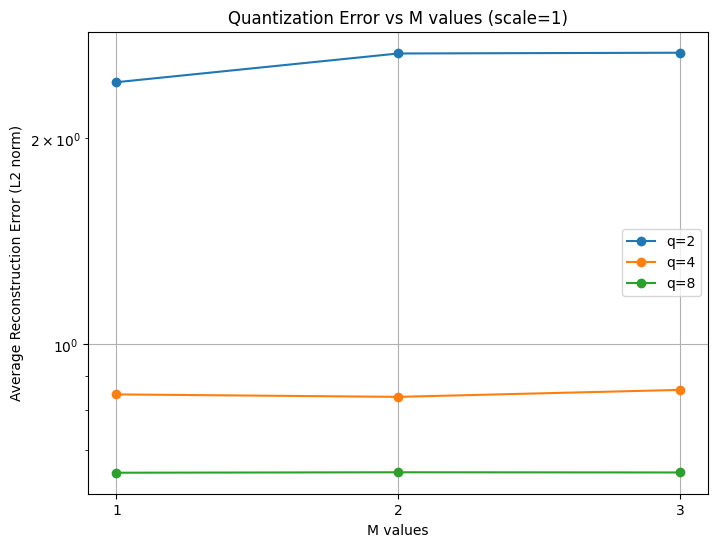


Summary of Average Reconstruction Errors (L2 norm):
           1          2          3
2  19.445217  18.678251  19.646430
4   6.891320   5.510737   4.301702
8   2.907195   1.023031   1.014360


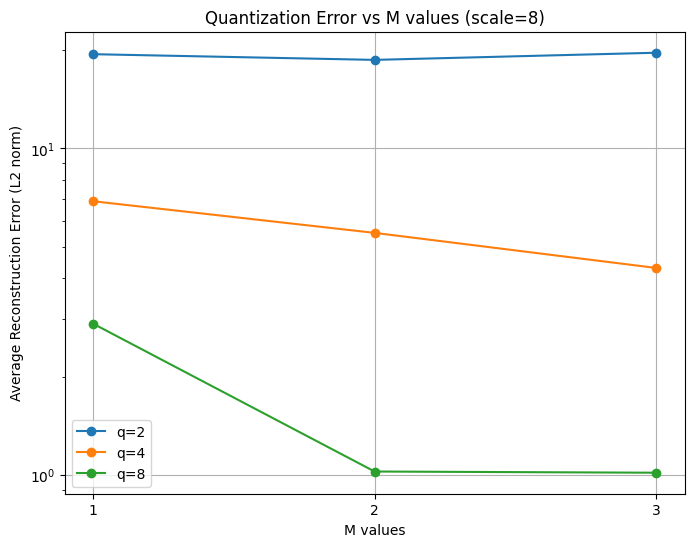


Summary of Average Reconstruction Errors (L2 norm):
            1           2           3
2  624.024783  637.182024  633.350774
4  237.995723  178.633406  170.033799
8   98.026130   42.505194   32.075738


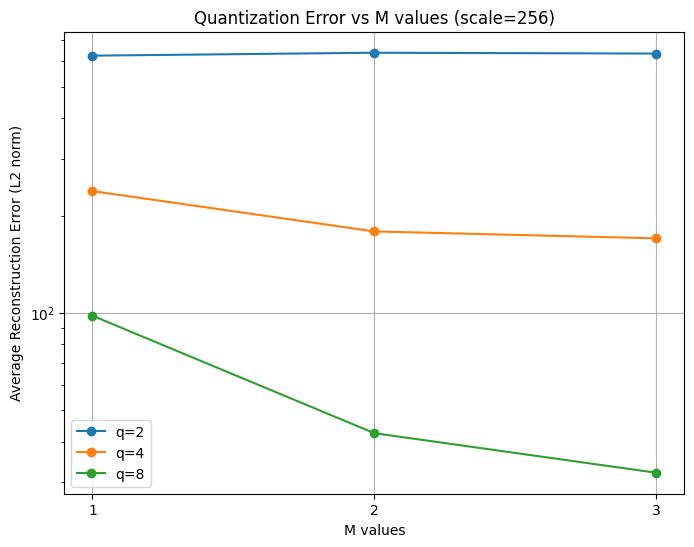

In [7]:
# we want to set alpha=0 to avoid scaling the lattice automatically
# to see the effect of varying q and M on the quantization error for a fixed scale of input vectors.
# but encoding routine gets into infinite loop. so we set alpha=1

def evaluate_quantization(scale=1, q_values=[2,4,8], m_values=[1,2,3],N=1000):
    er = np.zeros((len(q_values), len(m_values)))
    for i,q in enumerate(q_values):
        for j,m in enumerate(m_values):
            
            quantizer = HNLQ(
                        G=G,
                        Q_nn=Q_nn,
                        q=q,
                        beta=1,
                        alpha=1,
                        M=m,
                        eps=np.zeros(4),
                        dither=np.zeros(4) )
            for n in range(N):
                #test_sample = scale*np.random.uniform(-1,1,size=d)
                test_sample = scale*np.random.normal(0,1,size=d)
                enc, T = quantizer.encode(test_sample, with_dither=False)
                xh = quantizer.decode(enc,T, with_dither=False)
                error = np.linalg.norm(test_sample - xh)
                er[i,j] += error
            er[i,j] /= N
            
    df = pd.DataFrame(er, index=q_values, columns=m_values)
    print("\nSummary of Average Reconstruction Errors (L2 norm):")
    print(df)
    plt.figure(figsize=(8, 6))

    for i, q in enumerate(q_values):
        plt.plot(m_values, er[i], marker='o', label=f'q={q}')
    plt.xlabel('M values')
    plt.ylabel('Average Reconstruction Error (L2 norm)')
    plt.title(f'Quantization Error vs M values (scale={scale})')
    plt.xticks(m_values)
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    return er

# Try different M values
results = evaluate_quantization(scale=1, q_values=[2,4,8], m_values=[1,2,3])

# Try different scales
results = evaluate_quantization(scale=2**3, q_values=[2,4,8], m_values=[1,2,3])

# Try different scales
results = evaluate_quantization(scale=2**8, q_values=[2,4,8], m_values=[1,2,3])

So, increasing q increases the codebook size, and therefore, the rate, but it also allows for finer quantization at each level, which can reduce distortion. When the norm of the input is large, the reduction in distortion from increasing q can be significant. However, when the norm of the input is small, the benefit of increasing q may be less pronounced.

Both q and M affect the rate-distortion trade-off, but in different ways. Increasing q increases the codebook size and rate, while increasing M allows for finer quantization at the cost of complexity. The optimal choice of q and M depends on the specific application and the characteristics of the input data. Arbitrarily increasing either q or M will not always lead to better performance, and there are diminishing returns as these parameters are increased.

So, the norm of the input vector plays a crucial role in determining the effectiveness of increasing M and q in hierarchical lattice quantization. In particular, for the target rate of $R=M \log_2(q)$ per d-dimensions. if the norm is $q^M$, both increasing q and M can significantly reduce distortion. However, if the norm is much smaller than $q^M$, increasing M may have limited benefits, while increasing q can still help reduce distortion. However, monotonicity is not guaranteed.